In [0]:
!pip install spyder --upgrade
!pip install tsfresh --upgrade
from tsfresh import extract_features

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [0]:
# ECoG class contains signal and motion data and performs preprocessing procedure



def read_ECoG_from_csv(signal_file_path, motion_file_path):
    signal_df = pd.read_csv(signal_file_path)
    motion_df = pd.read_csv(motion_file_path)
    left_shoulder = motion_df.loc[0,motion_df.columns.str.contains('LSH')].values
    right_shoulder = motion_df.loc[0,motion_df.columns.str.contains('RSH')].values
    body_center = (left_shoulder - right_shoulder)/2 #It is a static point in this experiment
    motion_left_hand = motion_df[motion_df.columns[motion_df.columns.str.contains('Motion')].
                                 append((motion_df.columns[motion_df.columns.str.contains('LWR')]))].values
    motion_left_hand[:,1:] -= body_center #centering motion
    return signal_df.values, motion_left_hand

            
 

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
motion_link = 'https://drive.google.com/open?id=1MpK4BEZ5DcoUV0nE0oiVLKcWutRhUZKH'
ecog_link = 'https://drive.google.com/open?id=1heeTw2L2bFE9A16vq4Nn5V6mup3atEGR'

In [0]:
fluff, m_id = motion_link.split('=')
fluff, e_id = ecog_link.split('=')
downloaded_m = drive.CreateFile({'id':m_id}) 
downloaded_e = drive.CreateFile({'id':e_id})
downloaded_m.GetContentFile('Motions.csv')  
downloaded_m.GetContentFile('ECoG.csv')  

In [0]:
x,y = read_ECoG_from_csv("ECoG.csv","Motions.csv")

In [0]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [0]:
signal_data = np.array(x)
motion_data = np.array(y)

In [0]:
#simple synchronization
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = signal_data[signal_idx]
motion = motion_data[motion_idx]


Feature Extraction: 100%|██████████| 5/5 [03:48<00:00, 45.85s/it]
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7512834.208763356, tolerance: 2254.6083398015044
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44936.65431547841, tolerance: 232.52998681767448
  positive)


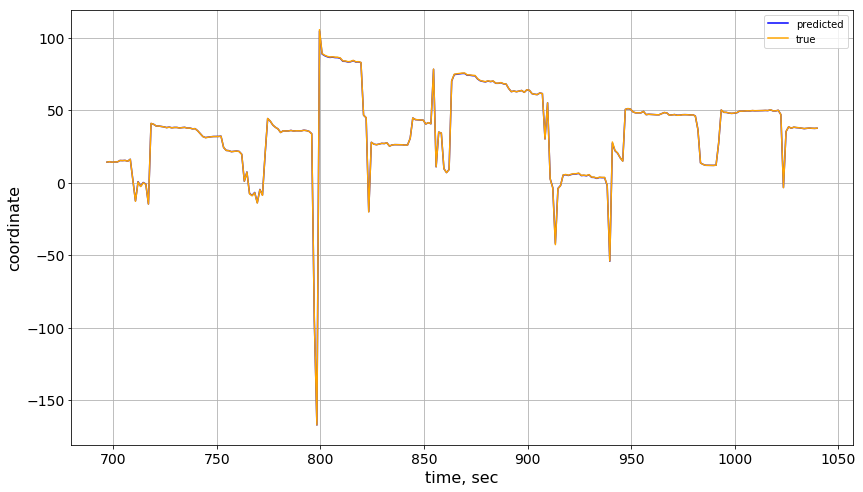

In [222]:
#feature_extracting. Model plotting. 
#Channels 5-8 are hardcoded due to long processing. They were chosen after brut force. Resulting r2-score on test data was 1.0.
#Other resulting models are saved in png files, we can take a look at them later
#Using Lasso (LinearRegression with l1-regularization) to choose from extracted features


from sklearn.linear_model import Lasso
import logging
logging.getLogger('tsfresh').setLevel(logging.ERROR)


title_font = {'size': 20, 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size': 16}

from tsfresh import extract_relevant_features
lr_clf = Lasso(alpha = 1.0, fit_intercept=True, normalize=False, random_state=42)
feat = []
channels = []
coef = []
scores = []
for i in np.arange(5, 9, 4):
    X_n = pd.DataFrame(ecog_signal[::150, i:i+4])
    X_n['time'] = time[::150]
    X_n['id'] = X_n.index
    motion_n = pd.Series(motion[::150,2])
    features_filtered_direct = extract_relevant_features(X_n, motion_n, column_id = 'id', column_sort = 'time')
    X_new = features_filtered_direct
    feat.append(list(X_new.columns))
    channels.append([i,i+4])
    
    X_train, x_test, y_train, y_test, t_train, t_test = train_test_split(X_new, motion[::150] ,time[::150], test_size = 0.33, shuffle = False)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(x_test)
    coef.append(lr_clf.coef_)
    scores.append([r2_score(y_pred[:, 2], y_test[:, 2]), mean_absolute_error(y_pred[:, 2], y_test[:, 2]), mean_squared_error(y_pred[:, 2], y_test[:, 2])])
    
    

    plt.figure(figsize = (14, 8))
    plt.plot(t_test, y_pred[:,2], color = 'blue', label = 'predicted')
    plt.plot(t_test, y_test[:,2], color = 'orange', label = 'true')
    plt.xticks( fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.xlabel('time, sec', **axis_font)
    plt.ylabel('coordinate', **axis_font)
    plt.grid(True)
    plt.legend()
    plt.show

In [0]:
#Loking at features extracted for x, y, z and their weights. If weight is less than 10e-5 then we assume the feature irrelevant

x_feat = []
y_feat = []
z_feat = []

for i in range(len(feat[0])):
    if round(coef[0][1][i],5) != 0:
        x_feat.append([feat[0][i], coef[0][1][i]])
    if round(coef[0][2][i], 5) != 0:
        y_feat.append([feat[0][i], coef[0][2][i]])
    if round(coef[0][3][i], 5) != 0:
        z_feat.append([feat[0][i], coef[0][3][i]])

In [252]:
#getting a list of features
set(np.array(z_feat+y_feat+x_feat)[:, 0])

{'0__abs_energy',
 '0__quantile__q_0.8',
 '1__abs_energy',
 '1__fft_coefficient__coeff_0__attr_"real"',
 '2__abs_energy',
 '2__fft_coefficient__coeff_0__attr_"angle"',
 '2__sum_values',
 '3__abs_energy',
 '3__fft_coefficient__coeff_0__attr_"angle"',
 '3__sum_values'}

In [0]:
#from the list above we form a new feature space. We have 10 features. And some experiments have shown that even this number can be reduced. But later.

signal_data = np.array(x)
motion_data = np.array(y)
features = []
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
for i in signal_idx[1:]:
    if i>10:
        f = []
        ecog_signal = signal_data[i-10:i+1, 5:9]
        f.append([sum(ecog_signal[:,0]**2), sum(ecog_signal[:,1]**2), sum(ecog_signal[:,2]**2), sum(ecog_signal[:,3]**2),\
                  sum(ecog_signal[:,3]), sum(ecog_signal[:,2]), np.quantile(ecog_signal[:, 0], 0.8),\
                  np.angle(fft(ecog_signal[:,2])[0]), np.angle(fft(ecog_signal[:,3])[0]), np.real(fft(ecog_signal[:, 1])[0])])
        features.append(np.array(f))
motion = motion_data[motion_idx[1:]]

In [0]:
#features are based on previous 10ms of raw data. hence, some values of motion should be trown away
motion = motion[len(motion)-len(features):]

In [0]:
#dummy stuff for shapes
X_tsf = []
for i in features:
    X_tsf.append(np.array(i).flatten())
X_tsf = np.array(X_tsf)

In [0]:
model = Lasso()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_tsf, motion, test_size = 0.5, shuffle = False)

In [0]:
model.fit(X_train, y_train)

In [0]:
y_pred = model.predict(X_test)

<function matplotlib.pyplot.show>

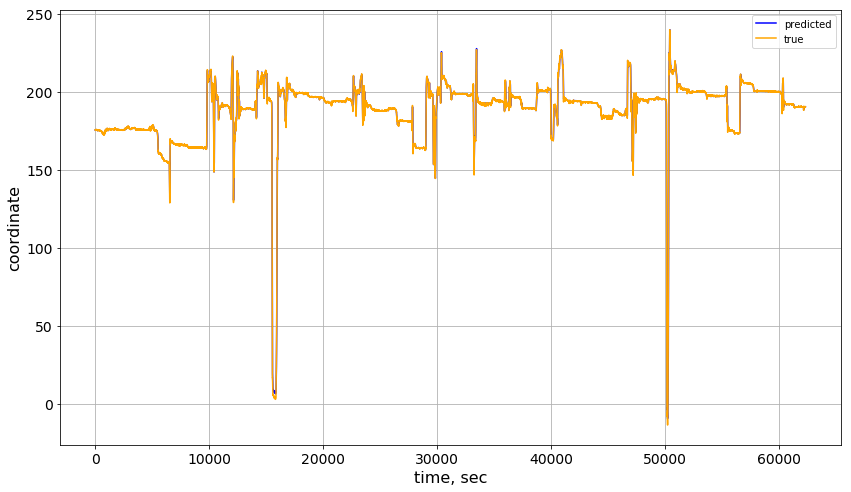

In [260]:
plt.figure(figsize = (14, 8))
plt.plot(y_pred[:,1], color = 'blue', label = 'predicted')
plt.plot(y_test[:,1], color = 'orange', label = 'true')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('time, sec', **axis_font)
plt.ylabel('coordinate', **axis_font)
plt.grid(True)
plt.legend()
plt.show

In [261]:
#score for prediction of x-coord
r2_score(y_pred[:,1], y_test[:, 1])

0.9958246570450062

In [262]:
#score for prediction of y-coord
r2_score(y_pred[:,2], y_test[:, 2])

0.9958535541158846

In [263]:
#score for prediction of z-coord
r2_score(y_pred[:,3], y_test[:, 3])

0.8754354696458364

In [0]:
#looking on the other day data from the same monkey with the same model (without even changing parameters of the model)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
motion_link2 = 'https://drive.google.com/open?id=1_iW3tUrzfa4PgFzgtpzTMp7pJs-OKYck'
ecog_link2 = 'https://drive.google.com/open?id=1xxSmgATPtstfDCzzfPHwlGRuvN16RVf_'
fluff, m_id = motion_link2.split('=')
fluff, e_id = ecog_link2.split('=')
downloaded_m = drive.CreateFile({'id':m_id}) 
downloaded_e = drive.CreateFile({'id':e_id})
downloaded_m.GetContentFile('Motions2.csv')  
downloaded_m.GetContentFile('ECoG2.csv')  

In [0]:
x2,y2 = read_ECoG_from_csv("ECoG2.csv","Motions2.csv")
signal_data2 = np.array(x2)
motion_data2 = np.array(y2)
time2, signal_idx2, motion_idx2 = np.intersect1d(signal_data2[:,0], motion_data2[:,0],assume_unique=True, return_indices=True)
ecog_signal2 = signal_data2[signal_idx2]
motion2 = motion_data2[motion_idx2]

In [0]:
features2 = []
time2, signal_idx2, motion_idx2 = np.intersect1d(signal_data2[:,0], motion_data2[:,0],assume_unique=True, return_indices=True)
for i in signal_idx2[1:]:
    if i>10:
        f = []
        ecog_signal2 = signal_data2[i-10:i+1, 5:9]
        f.append([sum(ecog_signal2[:,0]**2), sum(ecog_signal2[:,1]**2), sum(ecog_signal2[:,2]**2), sum(ecog_signal2[:,3]**2),\
                  sum(ecog_signal2[:,3]), sum(ecog_signal2[:,2]), np.quantile(ecog_signal2[:, 0], 0.8),\
                  np.angle(fft(ecog_signal2[:,2])[0]), np.angle(fft(ecog_signal2[:,3])[0]), np.real(fft(ecog_signal2[:, 1])[0])])
        features2.append(np.array(f))
motion2 = motion_data2[motion_idx2[1:]]

In [0]:
motion2 = motion2[len(motion2)-len(features2):]

In [0]:
X_tsf2 = []
for i in features2:
    X_tsf2.append(np.array(i).flatten())
X_tsf2 = np.array(X_tsf2)

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tsf2, motion2, test_size = 0.7, shuffle = False)

In [0]:
y_pred2 = model.predict(X_test2)

<function matplotlib.pyplot.show>

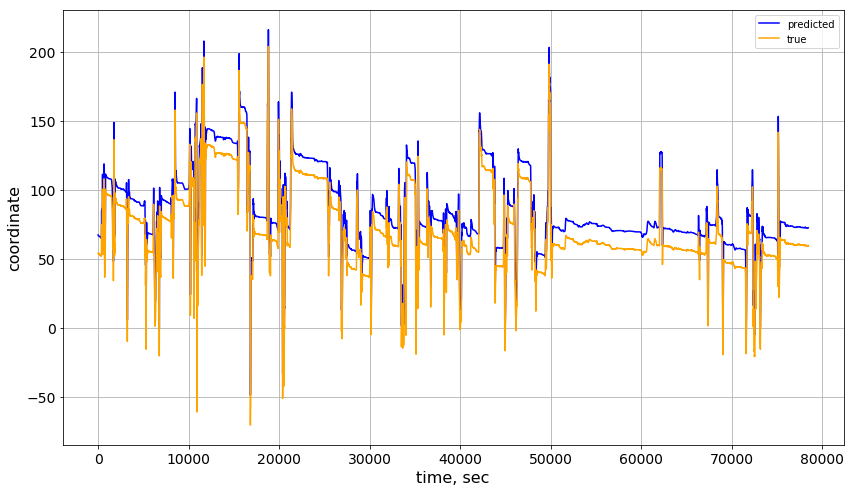

In [271]:
plt.figure(figsize = (14, 8))
plt.plot(y_pred2[:,1], color = 'blue', label = 'predicted')
plt.plot(y_test2[:,1], color = 'orange', label = 'true')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('time, sec', **axis_font)
plt.ylabel('coordinate', **axis_font)
plt.grid(True)
plt.legend()
plt.show

In [272]:
#score for prediction of x-coord
r2_score(y_pred2[:,1], y_test2[:, 1])

0.8077452042982692

In [273]:
#score for prediction of y-coord
r2_score(y_pred2[:,2], y_test2[:, 2])

0.11570284176697021

In [274]:
#score for prediction of z-coord
r2_score(y_pred2[:,3], y_test2[:, 3])

0.43565148004429055

In [0]:
#and now train on new data
model2 = Lasso()
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)

<function matplotlib.pyplot.show>

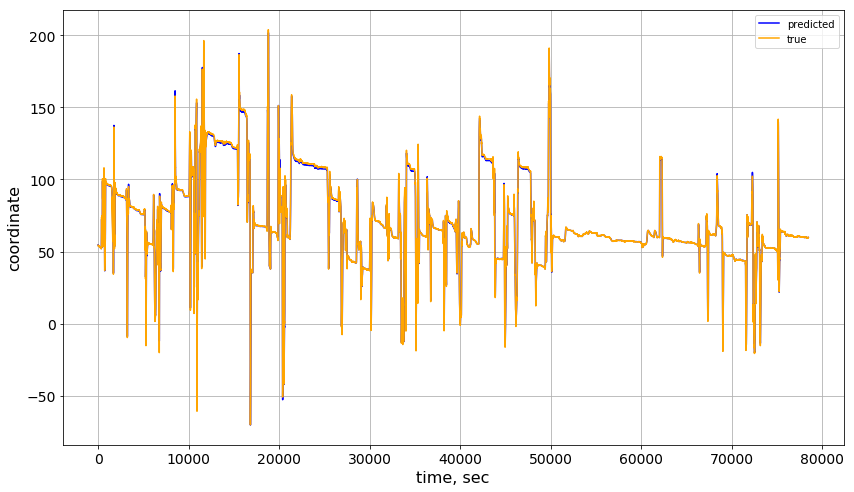

In [276]:
plt.figure(figsize = (14, 8))
plt.plot(y_pred2[:,1], color = 'blue', label = 'predicted')
plt.plot(y_test2[:,1], color = 'orange', label = 'true')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('time, sec', **axis_font)
plt.ylabel('coordinate', **axis_font)
plt.grid(True)
plt.legend()
plt.show

In [277]:
#score for prediction of x-coord
r2_score(y_pred2[:,1], y_test2[:, 1])

0.992067928460908

In [278]:
#score for prediction of y-coord
r2_score(y_pred2[:,2], y_test2[:, 2])

0.9898785120715263

In [279]:
#score for prediction of z-coord
r2_score(y_pred2[:,3], y_test2[:, 3])

0.9304689266023513